In [1]:
# working environment
!nvidia-smi

Wed Apr 12 12:57:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   40C    P8               37W / 390W|  23440MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color='red'>Import the necessary libraries</font>

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

2023-04-12 12:59:16.954182: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-12 12:59:16.991457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>The MNIST dataset is a widely recognized benchmark dataset in the field of machine learning and computer vision. It consists of a collection of grayscale images of handwritten digits from 0 to 9, with 60,000 images used for training and 10,000 images for testing. The dataset has been extensively used to evaluate the performance of image classification algorithms, showcasing a wide variety of writing styles and digit shapes. Achieving high accuracy on the MNIST dataset is considered a challenging task, and many models strive to achieve the best possible results.</font> 

## <font color='red'>To begin, let's import the dataset from the TensorFlow library.</font>

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## <font color='red'>I will display some example images from the MNIST dataset.</font>

In [5]:
def display_mnist_images(images, labels, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3))
    axes = axes.ravel()

    for i in np.arange(0, rows * cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(labels[i])

    plt.subplots_adjust(hspace=0.5)
    plt.show()

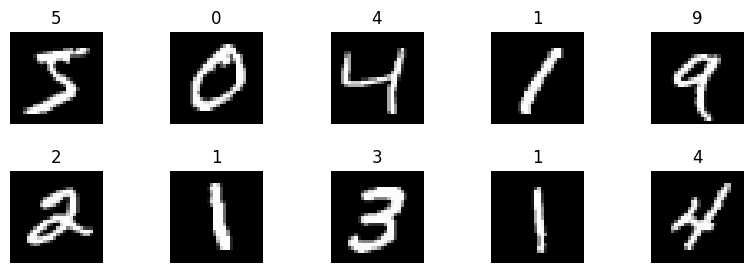

In [6]:
display_mnist_images(train_images[:10], train_labels[:10], rows=2, cols=5)

## <font color='red'>Before training, we need to preprocess the dataset and convert it into a tensor dataset. Let's perform these preprocessing steps.</font>

In [89]:
def preprocess(img, lbl):
    img = tf.reshape(img, img.shape + [1])
#     img = tf.keras.layers.Rescaling(1./255.)(img)   
    return img, lbl

In [90]:
train = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE).cache()
test = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

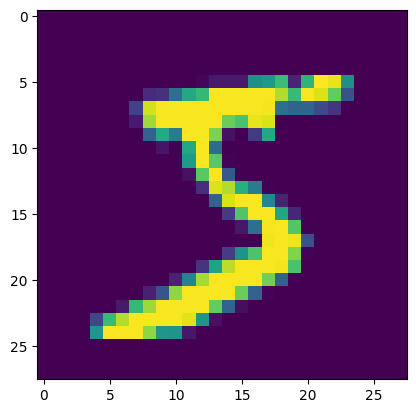

In [91]:
plt.imshow(x[0][0])

## <font color='red'>Now, let's define the architecture of our model.</font>

    Here, we will implement a parallel layer architecture with multiple branches of inputs, which will be concatenated later to see the results at the end.

In [98]:
inputs = tf.keras.layers.Input(shape=list(train_images[0].shape) + [1]) 

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x_1 = tf.keras.layers.MaxPooling2D((2, 2))(x) 
x_1 = tf.keras.layers.BatchNormalization()(x_1) 

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x_2 = tf.keras.layers.MaxPooling2D((2, 2))(x)  

x = tf.keras.layers.Concatenate()([x_1, x_2])
x = tf.keras.layers.Dense(32, activation="relu")(x) 
x = tf.keras.layers.Flatten()(x) 

x = tf.keras.layers.BatchNormalization()(x) 
x = tf.keras.layers.Dense(256, activation="relu")(x) 

x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(set(train_labels)), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs) 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

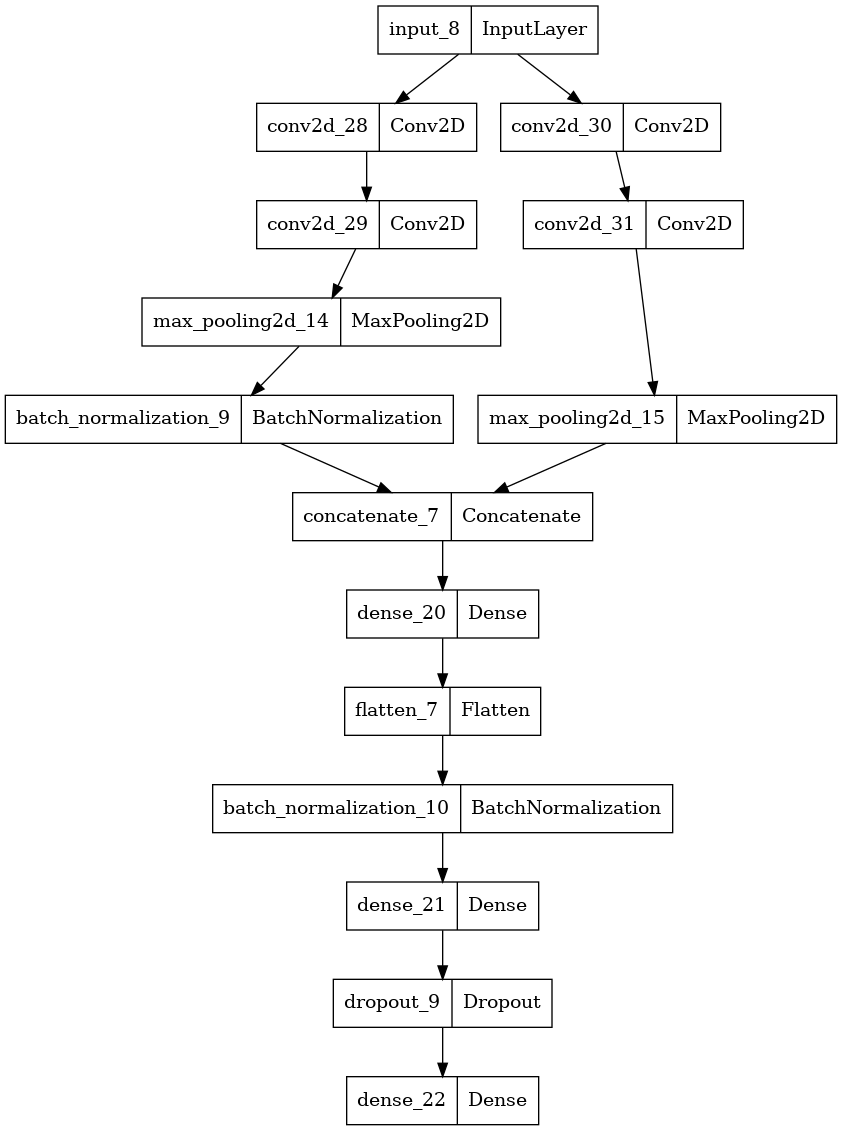

In [99]:
tf.keras.utils.plot_model(model)

## <font color='red'>Let's train our model.</font>

In [101]:
model_history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * 0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)])

Epoch 1/100
1875/1875 [==============================] - 23s 11ms/step - loss: 0.2660 - accuracy: 0.9339 - val_loss: 0.2034 - val_accuracy: 0.9435
Epoch 2/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1268 - accuracy: 0.9650 - val_loss: 0.1629 - val_accuracy: 0.9514
Epoch 3/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0969 - accuracy: 0.9735 - val_loss: 0.4307 - val_accuracy: 0.9583
Epoch 4/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1062 - accuracy: 0.9710 - val_loss: 0.0764 - val_accuracy: 0.9802
Epoch 5/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0817 - accuracy: 0.9778 - val_loss: 0.0707 - val_accuracy: 0.9821
Epoch 6/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0667 - accuracy: 0.9812 - val_loss: 0.0700 - val_accuracy: 0.9861
Epoch 7/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0674 - accuracy: 0.9820 - val_loss: 0

## <font color='red'>Let's save the trained model in the h5 format.</font>

In [102]:
model.save("saved-model.h5")

In [103]:
!ls saved-model.h5

saved-model.h5


## <font color='red'>Let's evaluate the performance of our model.</font>

In [109]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=12)
    plt.yticks(fontsize=12)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=12)

In [108]:
load_saved_model = tf.keras.models.load_model("saved-model.h5")

In [110]:
perf = load_saved_model.evaluate(test)
print("Testing accuracy: ", perf[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0812 - accuracy: 0.9884
Testing accuracy:  0.9883999824523926


313/313 [==============================] - 1s 4ms/step


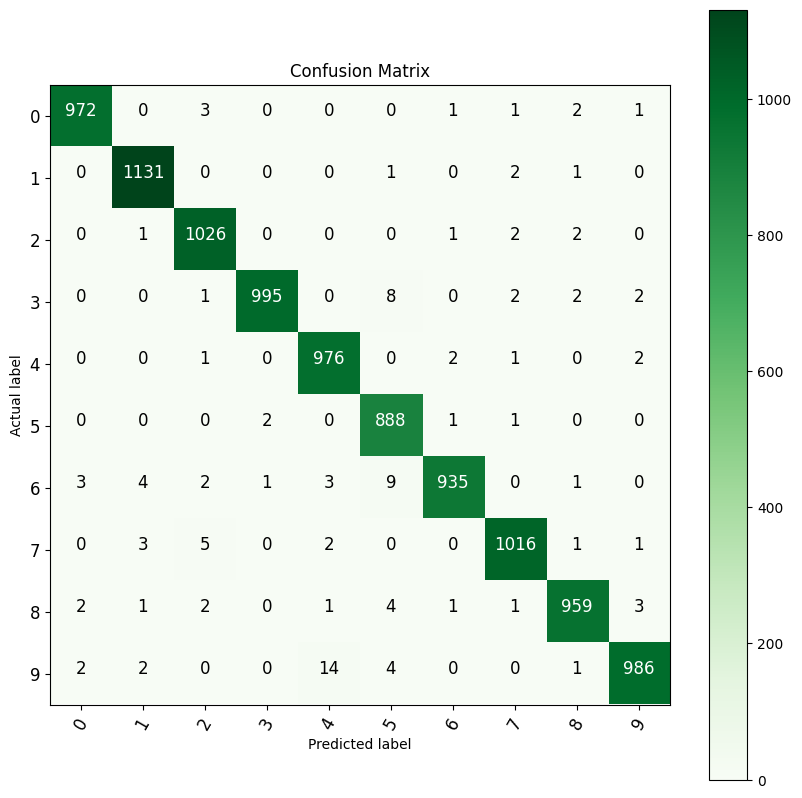

In [111]:
conf_matrix(y_test=test_labels, y_pred=load_saved_model.predict(test).argmax(axis=1), class_names=list(set(train_labels)))